# Project 1
Scrape and compute field_field_influence matrix described below. Display as directed graph using networkx package.

## Notation
- $a$ = number of unique authors
- $f$ = number of unique fields
field[q]
- Credit Matrix $C$
  - $a \times f$ matrix $C$ initialized with zeros
  - Each paper's field is given in its ArXiV record.
  - If a paper has $k$ authors, each author receives $\frac{1}{k}$ credit in that paper's field.
  - $C_{ij}$ = total credit for author $i$ in field $j$
  - Process:
      - for paper in ArXiV:
          - for auth in authors:
              - C\[auth, field\] += $\frac{1}{k}$
- Author Activity Matrix $A$
  - $a \times f$ matrix $A$ initialized as a copy of $C$
  - Divide by row sums: $A$ = make_stochastic($C$, axis=1)
  - $A_{ij}$ = proportion of all credit earned by author $i$ that comes from papers in field $j$ = proportion of author $i$ that "belongs" to field $j$
- Importance Matrix $I$
  - $a \times f$ matrix $I$ initialized as copy of $C$
  - Divide by columns sums: $I$ = make_stochastic($C$, axis=0)
  - $I_{ij}$ = proportion of all credit in field $j$ earned by author $i$ = importance of author $i$ in field $j$
- Field-Field Influence Matrix $B$
  - $f \times f$ matrix $B = A^T I$
  - $B_{ij}$ = influence by field $i$ on field $j$ = proportion of all credit in field $j$ attributable to field $i$.
  - $B_{ij} = \sum_k A^T_{ik} I_{kj} = \sum_k A_{ki} I_{kj} = \sum_k (\mbox{activity of author k in field i}) \cdot (\mbox{importance of author k in field j}) = \sum_k (\mbox{proportion of author k that "belongs" to field i}) \cdot (\mbox{importance of author k in field j})$




# Project 2 - Optimize funding using gradient descent


## Notation
- Use use $*$ to denote entry-wise multiplication that uses broadcasting rules.  This will distinguish from regular matrix multiplication.  Similarly, $/$ denotes entry-wise multiplication by the reciprocal of the second factor.

- Field Funding Vector $\$F$
  - $f$ vector whose entries sum to $1$
  - $\$F_i$ = proportion of all science funding currently going to field $i$
- Author Funding Vector $\$A$
  - $a$ vector $\$A = I\$F$
  - $\$A_i = \sum_j I_{ij} \$F_j$
  - Field $j$ distributes its funds $F_j$ to authors in proportion to their importance in that field.
  - An authors funding is the total of her funding from all fields
- Author Productivity
  - $a \times f$ matrix $P$
  - $P_{ij} = C_{ij} / \$A_i$ = credit by author $i$ in field $j$ per unit of funding
  - ASSUME this matrix is invariant - it is intrinsic to the author

Process:
0. Scrape ArXiV, compute $C$, $A$, $I$, $W$, $B$
1. Choose initial field funding Vector $\$F$.
2. Compute:
  - $\$A = I\$F$
  - $P = C / \$A$  (Note: This is entry-wise multiplication by the reciprocal.  This uses broadcasting rules.)  Assume $P$ does not vary.
3. Iterate the following system
  - Compute author funding $\$A = I\$F$
  - Compute new credit matrix $C = P * \$A$
  - Compute new importance matrix $I$
  - Compute new field funding vector using gradient descent
    - $C_{ij} = P_{ij} \$A_i = P_{ij} \sum_k I_{ik} \$F_k$
    - $\frac{\partial C_{ij}}{\partial \$F_k} = P_{ij} I_{ik}$
    - $C = \sum_{ij} C_{ij}$
    - $\frac{\partial C}{\partial \$F_k} = \sum_{ij} \frac{\partial C_{ij}}{\partial \$F_k} = \sum_{ij} P_{ij} I_{ik}$
    - $\nabla C = \langle \frac{\partial C}{\partial \$F_1}, \frac{\partial C}{\partial \$F_2}, \dots, \frac{\partial C}{\partial \$F_f} \rangle = I^T P 1_f$ where $1_f$ is an $f$-vectors of 1's.
    - $\$F_{new} = \$F_{old} + \frac{\nabla C}{||\nabla C||} \cdot \mbox{learning rate}$
4. This result will depend upon the chosen initial field funding vector.  Ideally, we will find some resource that gives a rough idea of the current real world funding.
  
  


In [1]:
%%time
%run -i setup.py
import string

sample_prop = 1.0

def make_stochastic(A, axis=0):
    A[A<0] = 0.0
    s = np.sum(A, axis=axis, keepdims=True)
    s[np.isclose(s,0.0)] = 1.0
    return A / s

# Download and import data
download = False # If download is true download and save data, else just read data
if(download):
    ## Data set
    data_url = "https://www.dropbox.com/s/mxlqmphe9dxtw8y/data_v3.csv?dl=1"
    df = pd.read_csv(data_url)
    df.to_csv("data.csv", index = False)
else:
    df = pd.read_csv("data.csv")
print(df.shape)

# Cleaning the dataframe
df.dropna(inplace = True)
print(df.shape)
df.drop_duplicates(subset = "title", keep = "last", inplace = True)
try:
    df.drop("Unnamed: 0", axis = 1, inplace = True) # Drop the "Unnamed: 0"
except:
    pass
print(df.shape)


num_papers = df.shape[0]
sample_size = int(sample_prop*num_papers)
sample = np.random.choice(np.arange(num_papers), sample_size, replace=False)
df = df.iloc[sample]

table = str.maketrans('', '', string.punctuation)
def clean(s):
    return s.lower().translate(table).strip()

all_auths = set()
for new_auths in df['authors'].tolist():
    all_auths.update((clean(name) for name in new_auths.split(';')))

all_auths = sorted(list(all_auths))
all_fields = sorted(list(set(df['category'].tolist())))

auth_dict = {auth:index for (index, auth) in enumerate(all_auths)}
field_dict = {field:index for (index, field) in enumerate(all_fields)}

# Creating the credit matrix
num_auths = len(all_auths)
num_fields = len(all_fields)
credit_orig = np.zeros((num_auths, num_fields), dtype=float)

for idx, (authors, field) in df[['authors','category']].iterrows():
    auths = [clean(name) for name in authors.split(";")]
    contribute = 1.0 / len(auths)
    for auth in auths:
        try:
            credit_orig[auth_dict[auth], field_dict[field]] += contribute
        except KeyError as e:
            print(e)

credit = credit_orig.copy()
activity = make_stochastic(credit, axis=1)
importance = make_stochastic(credit, axis=0)
influence = activity.T.dot(importance)
influence = pd.DataFrame(influence, index=all_fields, columns=all_fields)
display(margins(influence))

(2098183, 6)
(2098180, 6)
(1319569, 5)


,cs,econ,eess,math,physics:astro-ph,physics:cond-mat,physics:gr-qc,physics:hep-ex,physics:hep-lat,physics:hep-ph,...,physics:math-ph,physics:nlin,physics:nucl-ex,physics:nucl-th,physics:physics,physics:quant-ph,q-bio,q-fin,stat,TOTAL
cs,0.842,0.039,0.191,0.022,0.002,0.005,0.003,0.002,0.002,0.002,...,0.004,0.014,0.003,0.003,0.017,0.008,0.031,0.023,0.082,1.298
econ,0.000,0.725,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.726
eess,0.001,0.000,0.525,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.527
math,0.066,0.027,0.144,0.895,0.004,0.010,0.015,0.003,0.004,0.004,...,0.186,0.075,0.004,0.004,0.022,0.020,0.044,0.106,0.093,1.743
physics:astro-ph,0.004,0.000,0.009,0.002,0.919,0.007,0.074,0.021,0.006,0.027,...,0.005,0.014,0.020,0.018,0.034,0.006,0.006,0.004,0.008,1.202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
physics:quant-ph,0.007,0.000,0.012,0.006,0.003,0.039,0.028,0.002,0.011,0.009,...,0.046,0.035,0.007,0.017,0.044,0.726,0.015,0.015,0.008,1.059
q-bio,0.007,0.004,0.006,0.004,0.001,0.012,0.002,0.000,0.003,0.001,...,0.005,0.025,0.001,0.001,0.015,0.004,0.665,0.015,0.014,0.787
q-fin,0.002,0.007,0.001,0.003,0.000,0.002,0.001,0.000,0.001,0.000,...,0.002,0.003,0.000,0.001,0.004,0.001,0.005,0.650,0.007,0.691
stat,0.031,0.174,0.043,0.012,0.002,0.002,0.001,0.001,0.001,0.001,...,0.004,0.006,0.001,0.001,0.007,0.003,0.022,0.035,0.740,1.087


Wall time: 2min 34s


In [6]:
learn_rate = 0.1

eye = np.ones(num_fields)
def get_author_funding(credit, field_funding):
    importance = make_stochastic(credit, axis=0)
    author_funding = importance.dot(field_funding)[:,np.newaxis]    
    return make_stochastic(author_funding)

def run(credit, field_funding):
    field_funding = make_stochastic(field_funding)
    author_funding = get_author_funding(credit, field_funding)
    tol = 1e-8
    author_funding[author_funding<tol] = tol # numbers too small will distort productivity
    productivity = (1 / author_funding) * credit

    init_field_funding = field_funding.copy()
    init_credit = credit.copy()
    init_total_credit = np.sum(credit)
    
    best_field_funding = field_funding.copy()
    best_credit = credit.copy()
    best_total_credit = np.sum(credit)

    total_credit_rec = [init_total_credit]
    for step in range(500):
        author_funding = get_author_funding(credit, field_funding)
        credit = productivity * author_funding
        importance = make_stochastic(credit, axis=0)

        grad = (importance.T).dot(productivity).dot(eye)
        grad /= np.linalg.norm(grad)  # makes grad a unit vector
        field_funding += (grad * learn_rate)
        field_funding = make_stochastic(field_funding)
        
        total_credit = np.sum(credit)
        total_credit_rec.append(total_credit)
        if best_total_credit < total_credit:
            best_field_funding = field_funding.copy()
            best_credit = credit.copy()
            best_total_credit = total_credit

        # detect if system has converged by looking at relative variance of last "lag" steps
        lag = 25
        if step > lag:
            A = total_credit_rec[-lag:]
            if (np.std(A) / np.mean(A)) < 0.005:
                break
    print('initial total credit = {:.0f}, best total credit = {:.0f}'.format(init_total_credit, best_total_credit))
    display(pd.DataFrame({'init':init_field_funding, 'best':best_field_funding}, index=all_fields).sort_values(by='best',ascending=False),rows='all')
    plt.plot(total_credit_rec)
    plt.show()
    return best_field_funding, best_credit, best_total_credit


initial total credit = 1319569, best total credit = 23099888


,best,init
physics:quant-ph,0.409,0.002
physics:physics,0.150,0.007
physics:cond-mat,0.073,0.056
physics:nucl-th,0.059,0.006
math,0.059,0.047
physics:astro-ph,0.049,0.036
physics:hep-ph,0.034,0.033
cs,0.031,0.047
physics:hep-th,0.026,0.068
physics:math-ph,0.026,0.045


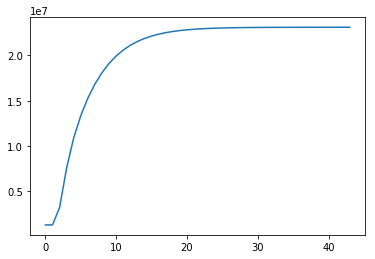

initial total credit = 1319569, best total credit = 10099266


,best,init
eess,0.235,0.000
physics:cond-mat,0.171,0.013
physics:nucl-th,0.124,0.004
physics:astro-ph,0.110,0.020
math,0.080,0.041
physics:physics,0.037,0.091
physics:quant-ph,0.035,0.057
physics:hep-ph,0.030,0.073
cs,0.029,0.057
physics:hep-th,0.026,0.057


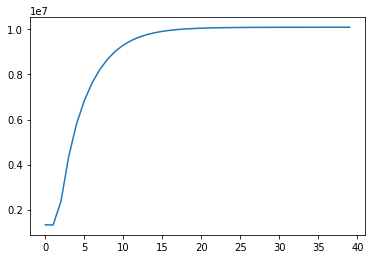

initial total credit = 1319569, best total credit = 2871069


,best,init
math,0.144,0.050
physics:cond-mat,0.126,0.038
stat,0.108,0.009
physics:astro-ph,0.104,0.049
physics:hep-ph,0.078,0.031
cs,0.061,0.051
physics:nucl-th,0.054,0.021
physics:physics,0.049,0.091
physics:hep-th,0.046,0.072
physics:gr-qc,0.043,0.024


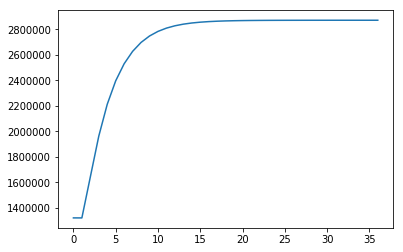

initial total credit = 1319569, best total credit = 1319569


,best,init
math,0.204,0.204
physics:astro-ph,0.139,0.139
physics:cond-mat,0.138,0.138
physics:physics,0.079,0.079
physics:hep-th,0.076,0.076
cs,0.069,0.069
physics:hep-ph,0.069,0.069
physics:quant-ph,0.063,0.063
physics:math-ph,0.030,0.030
physics:nucl-th,0.030,0.030


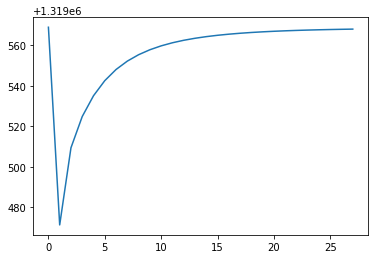

(array([6.94795043e-02, 1.74299336e-05, 2.25831313e-04, 2.03974176e-01,
        1.38815022e-01, 1.38025370e-01, 2.37532103e-02, 1.11165085e-02,
        7.34785373e-03, 6.90581546e-02, 7.56497008e-02, 2.97225837e-02,
        6.60139788e-03, 6.29751078e-03, 2.95247918e-02, 7.87908779e-02,
        6.30129989e-02, 1.65425226e-02, 5.62456378e-03, 2.64199902e-02]),
 array([[0.80606061, 0.        , 0.        , ..., 2.89978355, 0.93333333,
         0.11111111],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 1319568.9999999977)

In [7]:
iters = 500

best_field_funding_rec = []
best_credit_rec = []
best_total_credit_rec = []

best_field_funding_rec = []
best_field_funding_rec = []
for r in range(iters):
    rng = np.random.RandomState(r)
    field_funding = rng.rand(num_fields)
    funding, credit, total_credit = run(credit_orig, field_funding)
    best_field_funding_rec.append(funding)
    best_credit_rec.append(credit)
    best_total_credit_rec.append(total_credit)

    
# Assume current funding is based on the current credit martrix.  This should be a fixed point.
field_funding = make_stochastic(np.sum(credit_orig, axis=0))
funding, credit, total_credit = run(credit_orig, field_funding)
